In [194]:
import os
import glob
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import pydotplus 


# Features Extraction

In [189]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial_color_hist(img, color_space='YUV', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    else: feature_image = np.copy(img)             
    
    # color histogram
    hist_features=color_hist(feature_image)
    # Use cv2.resize().ravel() to create the feature vector
    bin_features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return bin_features, hist_features

def extract_hog(img, pix_per_cell=16, cell_per_block=1, orient=18, hog_idx=None):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
    if hog_idx is None:
        return hog_features
    else:
        return hog_features[hog_idx]

def extract_features(img, feature='hog', color_space='YUV', size=(32, 32), hog_idx=None):
    hog_features=extract_hog(img, hog_idx=hog_idx)
    if feature=='hog':
        return hog_features
    
    color_bin_features, color_hist_features=bin_spatial_color_hist(img, color_space, size)    
    features=np.concatenate((hog_features,color_bin_features, color_hist_features))
    return features


In [3]:
fpath=os.getcwd()+'/datasets/vehicles/KITTI_extracted/7.png'
img=cv2.imread(fpath)
features=extract_features(img,feature='all')
print(features.shape)


(3744,)


In [195]:
def process_datasets(features='hog', hog_idx=None, color_space='YUV'):
    if features=='hog':        
        if hog_idx is None:
            feat_size=4*4*18
        else:              
            feat_size=len(hog_idx)
    else:
        feat_size=3744
    
    # Vehicles
    subdir_lists=['KITTI_extracted','GTI_MiddleClose','GTI_Right','GTI_Left','GTI_Far']
    datasets_path=os.getcwd()+'/datasets/vehicles/'
    subdir=[os.path.join(datasets_path,o) for o in os.listdir(datasets_path) 
            if os.path.isdir(os.path.join(datasets_path,o))]

    x = None

    #for subpath in subdir:
    for subpath in subdir_lists:
        fcount=len(glob.glob1(datasets_path+subpath,'*.png'))
        x_temp=np.empty([fcount,feat_size])
        for i, fname in enumerate(glob.iglob(datasets_path+subpath+'/*.png')):  
            img=cv2.imread(fname)
            x_temp[i]=extract_features(img,feature=features,color_space=color_space, hog_idx=hog_idx)
            
        if x is None:
            x=x_temp
        else:
            x=np.vstack((x, x_temp))

    y=np.ones([x.shape[0]], dtype=int)


    # Non-vehicles
    datasets_path=os.getcwd()+'/datasets/non-vehicles/'
    subdir=[os.path.join(datasets_path,o) for o in os.listdir(datasets_path) 
            if os.path.isdir(os.path.join(datasets_path,o))]

    x_non = None

    for subpath in subdir:
        fcount=len(glob.glob1(subpath,'*.png'))
        x_temp=np.empty([fcount,feat_size])
        for i, fname in enumerate(glob.iglob(subpath+'*.png')):    
            img=cv2.imread(fname)
            x_temp[i]=extract_features(img, feature=features, color_space=color_space, hog_idx=hog_idx)
        if x_non is None:
            x_non=x_temp
        else:
            x_non=np.vstack((x_non, x_temp))

    y_non=np.zeros([x_non.shape[0]], dtype=int)

    # Stack both vehicle and non-vehicle datasets 
    y=np.hstack((y,y_non))
    x=np.vstack((x,x_non))

    # Normalise features
    X_scaler=StandardScaler().fit(x)
    X=X_scaler.transform(x)
    #X=x

    
    # Shuffle and split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3)

    return X_train, X_test, y_train, y_test



# SVM


In [82]:
X_train, X_test, y_train, y_test=process_datasets(features='hog_and_color', color_space='YUV')

clf=svm.LinearSVC()
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
val_acc=accuracy_score(y_test, y_pred)
print('Validation accuray %.4f'%val_acc)

KeyboardInterrupt: 

# Decision Tree
We use decision tree to examine which HOG feature is important. We will then use this information to explore pruning i.e. removing features that are not important, which can show significant reductino in the feature and hence improved computational time.

In [166]:
from sklearn import tree
X_train, X_test, y_train, y_test=process_datasets(features='hog',hog_idx=None)
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print(accuracy)

tree.export_graphviz(clf, out_file='tree.dot')

1.0


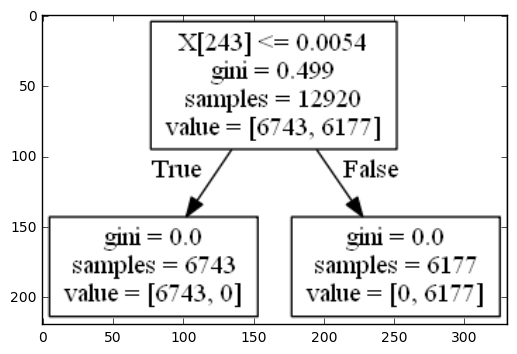

In [167]:
# Use command line to plot tree in image
#dot -Tpng tree.dot -o tree.png

plt.imshow(mpimg.imread('tree.png'))
plt.show()

In [168]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [193]:
def draw_hog_block(img_path):

    img=cv2.imread(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    cell_per_block=1
    pix_per_cell=16
    orient=18
    block_per_row=64/pix_per_cell

    hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=True)
    #hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

    #plt.plot(hog_features[5,7].ravel())
    #plt.show()

    hog_img=hog_img*255/np.max(hog_img)
    hog_img=cv2.cvtColor(hog_img.astype(np.uint8),cv2.COLOR_GRAY2BGR)


    for hog_feat_idx in [243]:
        block=(hog_feat_idx/orient)
        block_row=int((block/block_per_row))
        block_col=int(np.remainder(block,block_per_row))
        #print(block, block_row, block_col)
        top_left_corner=(block_col*pix_per_cell,block_row*pix_per_cell)
        bottom_right_corner=(top_left_corner[0]+pix_per_cell,top_left_corner[1]+pix_per_cell)
        #print(top_left_corner, bottom_right_corner)
        img=draw_boxes(img, [((top_left_corner), (bottom_right_corner))])
        hog_img=draw_boxes(hog_img, [((top_left_corner), (bottom_right_corner))])


    plt.subplot(121)
    plt.imshow(img)

    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.show()

#### Illutrate the HoG block that matters the most to making decision on a vehicle and a non-vehicle image. 

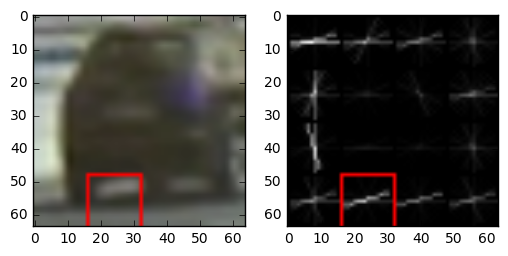

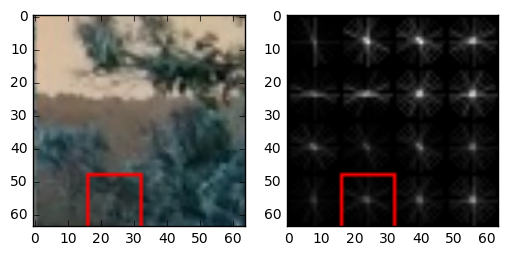

In [169]:
img_path=os.getcwd()+'/datasets/vehicles/GTI_Left/image0019.png'
draw_hog_block(img_path)

img_path=os.getcwd()+'/datasets/non-vehicles/Extras/extra9.png'
draw_hog_block(img_path)

## Decision Tree Pruning
Now try to fit decision tree using only 1 bin of HOG from previous result. The accuracy is the same as previously!

In [196]:
X_train, X_test, y_train, y_test=process_datasets(features='hog',hog_idx=[243])
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print('Test accuracy', accuracy)

Test accuracy 1.0
